In [1]:
import numpy as np
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
mode = 'local'
dataset = 'imagenet'
batch_size = {"librispeech": 512, "imagenet": 512}[dataset]

In [3]:
features = ["sim_compute_time", "threadpool_size", "block_size", 'io_time', 'processing_time', 'load_time', 'compute_time', 'completion_time', "memory", "throughput", 'num_batches']
def plot_rlt(dirs):
    data = []
    for dir in dirs:
        sim_compute_time = float(dir.split('/')[-1].split('-')[0].split('=')[1])
        
        num_batches = len(np.load(f"{dir}/data_load_time.npy"))
        load_time = np.mean(np.load(f"{dir}/data_load_time.npy"))
        compute_time = np.mean(np.load(f"{dir}/compute_time.npy"))
        completion_time = load_time + compute_time
        throughput = batch_size / completion_time

        memory_usage = np.load(f"{dir}/memory.npy", allow_pickle=True)
        memory = []
        for row in memory_usage:
            tmp = list(row.values())
            if len(tmp) < 2:
                continue
            tmp = [int(x) for x in tmp]
            memory.append(sum(tmp))
        memory = np.quantile(memory, 0.9, axis=0) / (1024 ** 2)
       
        try:
            block_size = int(dir.split('/')[-1].split('-')[1].split('=')[1])
        except:
            block_size = 1
        
        threadpool_size = 1
        if os.path.exists(f"{dir}/opt_config"):
            with open(f"{dir}/opt_config", 'r') as f:
                opt_config = f.readline().strip('\n').split(',')
                threadpool_size, block_size = opt_config
                threadpool_size, block_size = int(threadpool_size), int(block_size)
        
        io_time = np.mean(np.load(f"{dir}/io_time.npy")) / block_size
        processing_time = np.mean(np.load(f"{dir}/processing_time.npy"))
        processing_time -= io_time
        
        data.append([sim_compute_time, threadpool_size, block_size, io_time, processing_time, load_time, compute_time, completion_time, memory, throughput, num_batches])
    return data

# Exp1
Evaluate the dataset merging algorithm with our job and dataset placement algorithm:
- Scenario: 1-job/1-worker
- Datasets: ImageNet, LibriSpeech
- Baselines:
    - No merging: load individual files
    - Fixed Size Block: enumerate and benchmark multiple block sizes until meeting the early stop condition. (<= 5% imp for 3 block sizes) 
- Metrics:
    - Data loading time
    - Job completion time
    - Memory utilization

## Baseline 1: No merging

In [4]:
baseline1 = pd.DataFrame()
for i in range(3):
    dirs = glob.glob(f"./experiments/exp1/baseline1/{dataset}/run{i+1}/{mode}/sim*")
    # dirs = glob.glob(f"./experiments/exp1/baseline1/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    baseline1 = pd.concat([baseline1, data], axis=0)

std = baseline1.groupby('sim_compute_time').std()['throughput'].to_numpy()
baseline1 = baseline1.groupby('sim_compute_time').mean()
baseline1['throughput_std'] = std

baseline1.sort_values(by='sim_compute_time', inplace=True)
baseline1.reset_index(inplace=True)
baseline1

,sim_compute_time,threadpool_size,block_size,io_time,processing_time,load_time,compute_time,completion_time,memory,throughput,num_batches,throughput_std
0,0.10,1.0,1.0,0.001088,0.013502,0.908172,0.166724,1.074896,4566.343750,476.376973,68.0,6.095607
1,0.25,1.0,1.0,0.000814,0.013815,0.751806,0.320125,1.071932,4937.502995,477.795129,68.0,10.499779
2,0.50,1.0,1.0,0.000231,0.014398,0.493607,0.581833,1.075440,4804.765625,476.295192,68.0,12.315291
3,0.75,1.0,1.0,0.000236,0.014467,0.280792,0.831585,1.112377,4789.187500,460.364790,68.0,7.818765
4,1.00,1.0,1.0,0.000456,0.014210,0.130698,1.070927,1.201624,5925.763021,426.090281,68.0,0.509740


## Baseline 2: Fixed Block Size

In [5]:
dirs = glob.glob(f"./experiments/exp1/baseline2/local/sim*")
data = plot_rlt(dirs)
data = pd.DataFrame(data, columns=features)
data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)

In [6]:
baseline2 = pd.DataFrame()
for i in range(1):
    dirs = glob.glob(f"./experiments/exp1/baseline2/{dataset}/{mode}/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)
    # rlt = pd.DataFrame()
    # for name, group in data.groupby(by="sim_compute_time"):
    #     group.sort_values(by="completion_time", inplace=True)
    #     group = group.iloc[0].to_frame().T
    #     rlt = pd.concat([rlt, group])
    # baseline2 = pd.concat([baseline2, rlt], axis=0)

data

,sim_compute_time,threadpool_size,block_size,io_time,processing_time,load_time,compute_time,completion_time,memory,throughput,num_batches
2,0.1,1,10,0.000669,0.002816,0.650994,0.175602,0.826595,8184.828125,619.408399,68
1,0.1,1,20,0.000510,0.002364,0.590675,0.189303,0.779978,7759.941406,656.428770,68
7,0.1,1,30,0.000519,0.002961,0.563134,0.199014,0.762149,8173.414062,671.785023,68
6,0.1,1,40,0.000523,0.003700,0.530935,0.210821,0.741756,8432.187500,690.253954,68
4,0.1,1,100,0.000588,0.004792,0.482112,0.231124,0.713236,7523.041406,717.855190,68
0,0.1,1,200,0.000767,0.005207,0.491147,0.242381,0.733529,9269.019531,697.995802,68
8,0.1,1,300,0.000877,0.004761,0.489692,0.241434,0.731126,10331.214844,700.289484,68
5,0.1,1,400,0.000950,0.004558,0.508183,0.236437,0.744620,8395.234375,687.598867,68
3,0.1,1,500,0.000946,0.002671,0.495991,0.264152,0.760142,11561.798437,673.558111,68


## Ours

In [7]:
# for f in glob.glob(f"./experiments/exp1/ours/{mode}/sim*/imagenet*.csv"):
#     df = pd.read_csv(f)
#     df['block_size'] = df['block_size'].astype(np.int32)
#     x = np.arange(df.shape[0])

#     plt.plot(x, df['batch_completion_time'], label=f.split('/')[-2])
#     # plt.xticks(x, df['block_size'], rotation=90)

# plt.legend()
# plt.xlabel("block_size(# samples)")
# plt.ylabel("batch completion time(s)")
# plt.grid()
# plt.show()

In [8]:
ours = pd.DataFrame()
for i in range(3):
    dirs = glob.glob(f"./experiments/exp1/ours/{dataset}/run{i+1}/{mode}/sim*")
    # dirs = glob.glob(f"./experiments/exp1/ours/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)

    rlt = pd.DataFrame()
    for name, group in data.groupby(by="sim_compute_time"):
        group.sort_values(by="completion_time", inplace=True)
        group = group.iloc[0].to_frame().T
        rlt = pd.concat([rlt, group])
    ours = pd.concat([ours, rlt], axis=0)

std = ours.groupby('sim_compute_time').std()['throughput'].to_numpy()
ours = ours.groupby('sim_compute_time').mean()
ours['throughput_std'] = std
ours.sort_values(by='sim_compute_time', inplace=True)
ours.reset_index(inplace=True)
ours

,sim_compute_time,threadpool_size,block_size,io_time,processing_time,load_time,compute_time,completion_time,memory,throughput,num_batches,throughput_std
0,0.10,2.333333,173.333333,0.000593,0.005103,0.479560,0.247166,0.726725,9226.110677,704.547650,68.0,4.288590
1,0.25,3.333333,160.000000,0.000627,0.005319,0.323054,0.410383,0.733436,7455.864193,698.134707,68.0,7.330521
2,0.50,3.666667,160.000000,0.000593,0.005189,0.148089,0.642886,0.790975,8800.657943,647.452726,68.0,12.085340
3,0.75,4.666667,173.333333,0.000469,0.003506,0.104710,0.833167,0.937878,11945.343750,545.936422,68.0,4.351139
4,1.00,2.666667,186.666667,0.000493,0.002719,0.101776,1.058236,1.160012,12807.913151,441.385928,68.0,2.744761


In [9]:
100 * (ours['throughput'] - baseline1['throughput']) / baseline1['throughput']

0    47.897084
1    46.115911
2    35.935180
3    18.587788
4     3.589767
Name: throughput, dtype: float64

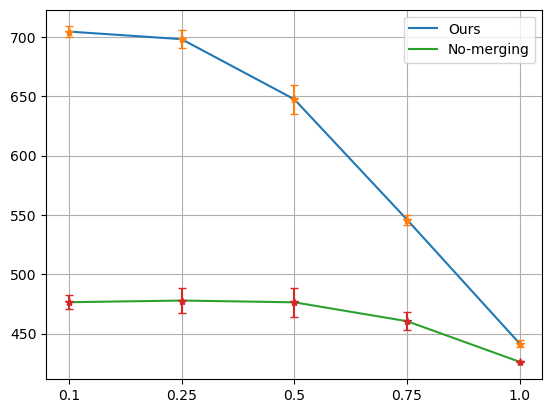

In [10]:
x = np.arange(len(ours['sim_compute_time']))
plt.plot(x, ours['throughput'], label='Ours')
plt.errorbar(x, ours['throughput'], yerr = ours['throughput_std'], fmt ='*', capsize=3)
plt.plot(x, baseline1['throughput'], label='No-merging')
plt.errorbar(x, baseline1['throughput'], yerr = baseline1['throughput_std'], fmt ='*', capsize=3)

plt.xlabel = 'Simulated GPU Computation Time (s) / Batch'
plt.ylabel = 'Throughput (samples/s)'
plt.xticks(x, ours['sim_compute_time'])
plt.grid()
plt.legend()
plt.show()

In [11]:
ours.to_csv('./experiments/exp1/ours-imagenet-local.csv', index=None)
baseline1.to_csv('./experiments/exp1/baseline-imagenet-local.csv', index=None)

In [12]:
traces = glob.glob(f"./experiments/exp1/ours/imagenet/run3/remote/sim*/imagenet*")
traces.sort(key=lambda x: float(x.split('/')[-2].split('=')[1]))
image_traces_data = []
compute_times = []
for trace in traces:
    compute_times.append(trace.split('/')[-2].split('=')[1])
    df = pd.read_csv(trace)
    image_traces_data.append(df)
# traces_data

In [13]:
traces = glob.glob(f"./experiments/exp1/ours/librispeech/run3/remote/sim*/deepspeech*")
traces.sort(key=lambda x: float(x.split('/')[-2].split('=')[1]))
speech_traces_data = []
compute_times = []
for trace in traces:
    compute_times.append(trace.split('/')[-2].split('=')[1])
    df = pd.read_csv(trace)
    speech_traces_data.append(df)
# traces_data

In [14]:
compute_times

['0.1', '0.25', '0.5', '0.75', '1.0']

/var/folders/nc/bx1f84cn0s70w7gxwrctqp3h0000gn/T/ipykernel_65076/2633854641.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./searchprocess.png', dpi=300, tight_layout=True, bbox_inches='tight')


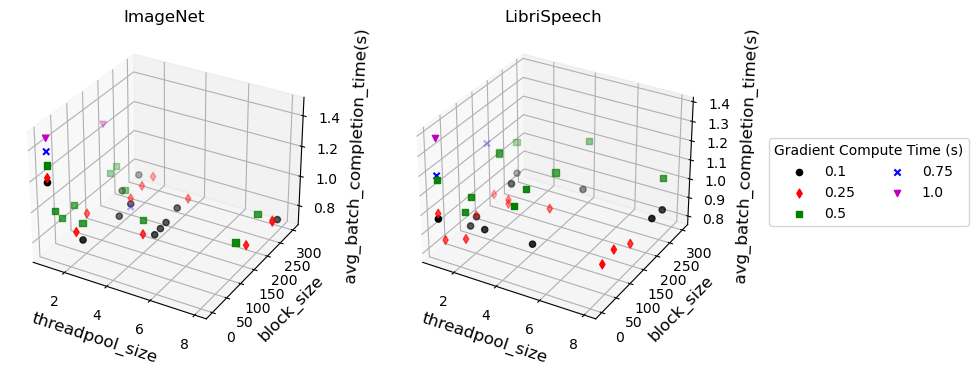

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-deep')

# 创建一个新的3D图像
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['o', 'd', 's', 'x', 'v']
colors = ['k', 'r', 'green', 'b', 'm']
scatters = []
for i, df in enumerate(image_traces_data):
    # 使用 scatter 方法创建3D散点图
    image_scatter = ax1.scatter(df['threadpool_size'], df['block_size'], df['batch_completion_time'], label=compute_times[i], marker=markers[i], color=colors[i])
    scatters.append(image_scatter)

for i, df in enumerate(speech_traces_data):
    # 使用 scatter 方法创建3D散点图
    speech_scatter = ax2.scatter(df['threadpool_size'], df['block_size'], df['batch_completion_time'], label=compute_times[i], marker=markers[i], color=colors[i])
    scatters.append(speech_scatter)

ax1.set_xlabel('threadpool_size', fontsize=12)
ax1.set_ylabel('block_size', fontsize=12)
ax1.set_zlabel('avg_batch_completion_time(s)', fontsize=12)
ax1.set_title('ImageNet')

ax2.set_xlabel('threadpool_size', fontsize=12)
ax2.set_ylabel('block_size', fontsize=12)
ax2.set_zlabel('avg_batch_completion_time(s)', fontsize=12)
ax2.set_title('LibriSpeech')

legend_title = "Gradient Compute Time (s)"
# fig.legend(handles=scatters, title=legend_title, labels=compute_times, loc="right", bbox_to_anchor=(0.75, 1.0), ncol=5)
fig.legend(handles=scatters, title=legend_title, labels=compute_times, loc="right", bbox_to_anchor=(1.13, 0.5), ncol=2)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.savefig('./searchprocess.png', dpi=300, tight_layout=True, bbox_inches='tight')
plt.show()